# GP based system identification of reactor dynamics

## Some background

In this notebook we will go through the GP-system identification model for reactor dynamics. 
The core of the GP-bases system idenfitication is the assumption that the dynamics is following the state space model as below
$$
x_{t+1} = f(x_t,u_t) + v_t,\\
y_t = g(x_t,u_t) + w_t
$$

- Ideally, the measurement equation $g(x_t,u_t)$ that relates between the "latent" states and the observation should be known. 
- However, for the reactor dynamics, it is not possible to come up with such an equation.
- Therefore, we model both $f$ and $g$ as GP's.
- The GP enters the *SSM* by assuming that
$$
f(x_t,u_t) \sim {GP} (m_f(x_t,u_t),k_f(x_t,u_t,x_t',u_t')),\\
g(x_t,u_t) \sim {GP} (m_g(x_t,u_t),k_g(x_t,u_t,x_t',u_t')),\\
x_0 \sim p(x_0), \\
f_t := f(x_{t-1}),\\
x_t|f(x_{t-1}) \sim  \mathcal{N}(0,Q),\\
g_t := g(x_t),\\
y_t|g_t \sim \mathcal{N}(0,R).
$$

- There could be many ways to build the GP based inference as above.
- One idea, is to lump the dynamics of the observation as a state as given in this [reference](https://www.repository.cam.ac.uk/handle/1810/299413).
- That is now, we only have GP for the transition function $f$, where the new latent state $z$ are the original latent states and the observations
- The observations are some of the last elements in $z_t$
$$
f(z_t,u_t) \sim {GP} (m_f(z_t,u_t),k_f(z_t,u_t,z_t',u_t')),\\
z_0 \sim p(x_0), \\
f_t := f(z_{t-1}),\\
z_t|f(z_{t-1}) \sim  \mathcal{N}(0,Q),\\
$$

- Now, we can use $m_f$ as a linear dynamics with the structure
 $$
 m_f(z_t,u_t) = A_0 z_t + B_0 u_t.
 $$
 - The matrices $A$ and $B$ are obtained from linear system identification procedure
 - Using finite dimensional approximation of the GP of $f$, we write
 $$
 f \sim A_0 z_t + B_0 u_t + A \Phi(z_t, u_t)
 $$
 - Here, $\Phi$ is a basis function, with the dimension is $n_z \times n_b^{n_z+n_u}$.  
 - The matrix $A$ to be sampled by some MCMC, also the covariance matrix $Q$.

## Implementation

Since the algorithm is a typical **MCMC** algorithm that needs quite a long time to run, the GP-sysid is written so that it can run in a cluster.

- We implement this in `chemReactor.py`, where all necessary computations are given in `a.py` and `util.py`.
- To run the simulation, `python chemReactor.py --parameters` where the list of parameters can be seen in `python chemReactor.py --help`.
- We will use `Numba` to excel the speed and  `SIPPY` which is linear system identification toolbox which can be downloaded from [here](https://github.com/CPCLAB-UNIPI/SIPPY). `Numba` should be installabe from `conda`. 
- To be able to run the code, `Numba` version should be later than `0.47`.
- Now we will show some important sections in these python files.
- Fist is the core function in `chemReactor.py`
```python
def chemReactorGP(path,randSeed=0,resampling=5,ma_smoother=14,
                    data_extension_percentage=50,
                    minSS_orders=5,maxSS_orders=8,useLinear=True,
                    samples_num=1000,particles_num=30,
                    bases_num=4,ratio_L=1,Kn=10,
                    burnPercentage=25,lQ=100,ell=1.,Vgain=1e3):
```

- Inside this function come some basic things like :
  - loading the data, We only select three $\Delta T$
     ```python
        data = sio.loadmat('ForIdentification.mat')
        u = data['u'][::resampling,:];u = u.T#u=u[np.newaxis,:]
        y = data['y'][::resampling,:3];y = y.T#y=y[np.newaxis,:]
        yVal = data['yVal'][::resampling,:3]; yVal=yVal.T
     ```
  - Here `u` is the aromatics and sulfur inlet, and `y` are the $\Delta T$s

  - Next we extend both `u`, `y`, and `yVal`, to match with the basis function condition
      ```python
        extension = data_extension_percentage # 50% extension
        if extension != 0:
            y_extend = np.zeros((y.shape[0],(y.shape[1]*(100+extension)//100)))
            yVal_extend = np.zeros((y.shape[0],(yVal.shape[1]*(100+extension)//100)))
            u_extend = np.zeros((u.shape[0],(u.shape[1]*(100+extension)//100)))
            shift = extension*y.shape[1]//200
            y_extend[:,shift:-shift] = y
            yVal_extend[:,shift:-shift] = yVal
            u_extend[:,shift:-shift] = u
        else:
            y_extend = y
            yVal_extend = yVal
            u_extend = u
            
        y_extend = util.moving_average(y_extend.T,ma_smoother).T
        yVal_extend = util.moving_average(yVal_extend.T,ma_smoother).T

        # plt.plot(y.T)
        # plt.plot(y_ma.T)
        # %%
        # T_test = T
        u_test = u_extend
        y_test= yVal_extend
        u_train = u_extend
        y_train = y_extend

      ```
  - Next we first run the linear system identification
       ```python
        #%%
        sys_id = sippy.system_identification(y_train.T,u_train.T,'N4SID'
                                        #  ,centering='InitVal'
                                        #  ,SS_p=horizon,SS_f=horizon
                                        ,SS_A_stability=True
                                        ,IC='AIC'
                                        ,SS_orders=[minSS_orders,maxSS_orders]
                                        )

        #%%
        nx = sys_id.A.shape[0]
        iA = sys_id.A #np.random.randn(nx,nx)
        iB = sys_id.B #np.ones((nx,1))
        #%%
        # nbases=4
        L = y.shape[1]//ratio_L
        steps = samples_num
       ```
  - We create `Simulation` instance, and initialize its parameters
       ```python
        sim = a.Simulate(steps,nx,u_train,y_train,bases_num,L,PFweightNum=particles_num)
        if useLinear:
            sim.iA = iA
            sim.iB = iB 
        ```
        
        ```python
        sim.burnInPercentage = burnPercentage
        sim.lQ = lQ #for prior QR
        sim.ell = ell
        sim.Vgain = Vgain
        ```
  - Lastly we run the simulation by `sim.run()`, do the evaluation using the test data by `sim.evaluate()` and save the result in `hdf5` file by `sim.save(...)`
      ```python
        sim.run()
        #%%
        y_test_med,y_test_loQ,y_test_hiQ = sim.evaluate(y_test,u_test,Kn=Kn)

        sim.save(str(simResultPath/'result.hdf5'))
      ```

- The particle filter and MCMC part is implemented in `a.py`
- Some snippets:
- Implementation of `run()`
    ```python
    def run(self):
        
        for k in trange(self.__steps,desc='Simulation'):
            #This probabiy not required
            self.setToZero()           
            #Initialization
            if k>0:
                self.__xPF[-1,:,:] = self.__x_prim
            
            self.__PFweight[0,:] = 1.
            self.__PFweight[0,:] /= np.sum(self.__PFweight[0,:])
            
            # CPF with ancestor sampling
            self.__xPF[:-1,:,0] = 0
    ```
    ```python
            self.__runParticleFilter(k)
            star = util.systematic_resampling(self.__PFweight[-1,:],1)
            self.__x_prim[:,-1] = self.__xPF[star,:,-1].flatten()

            #loop from the back
            for t in np.flip(np.arange(1,self.__timeStep)):
                star = self.__a[t,star]
                self.__x_prim[:,t-1] = self.__xPF[star,:,t-1].flatten()
            # print('Sampling. k = {}/{}'.format(k,self.__steps))
            self.__update_statistics()
    ```
- Both `__update_statistics()` and `__runParticleFilter(k)` implemented in `util.py`

## Results

- After several trial and errors with the parameter of the simulations, the simulation result is still very bad.
- One of the possible problem is that because lumping the observation into the latent state is problematic.
- Other possible bottle neck is that the basis function $\Phi$ dimension grows exponentially with the number of state $n_z$. 
- Selecting a higher state than $4$ is not feasible using basis number $5$.
- While at the same time the dynamic it self probably more than that.

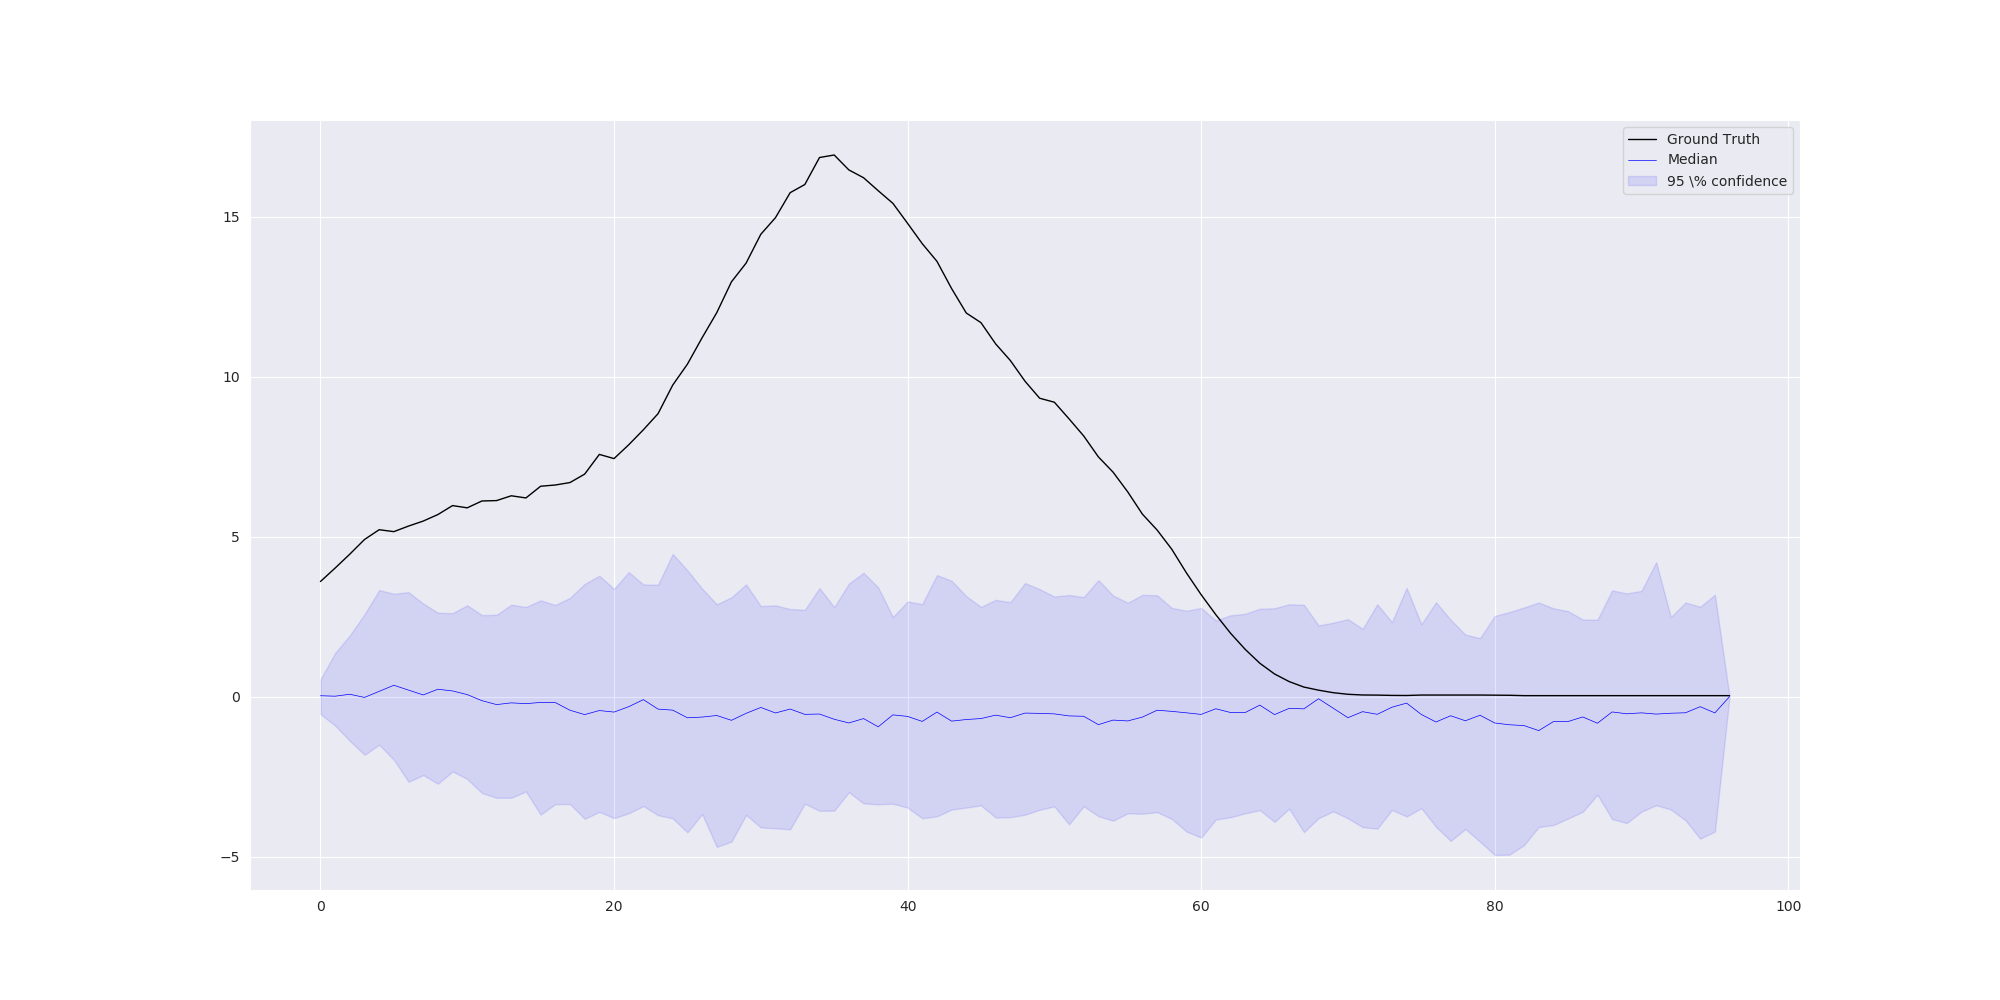
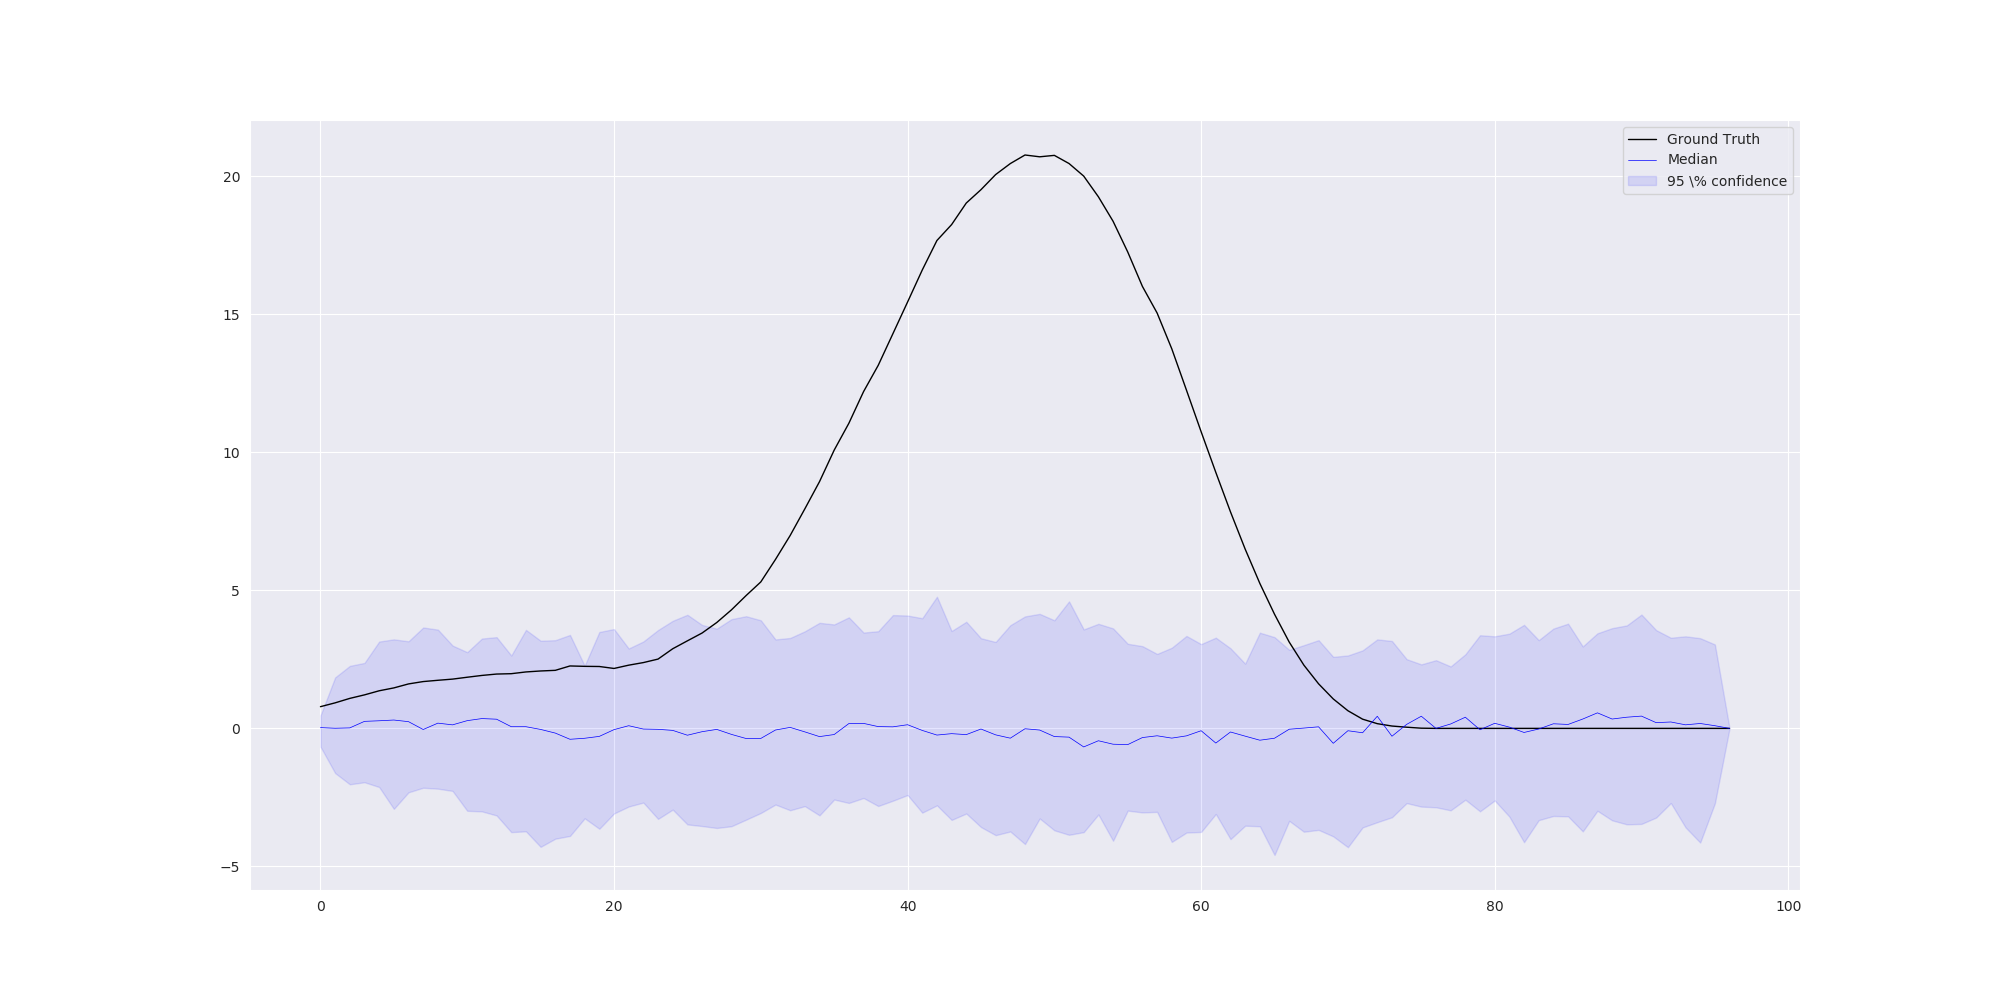
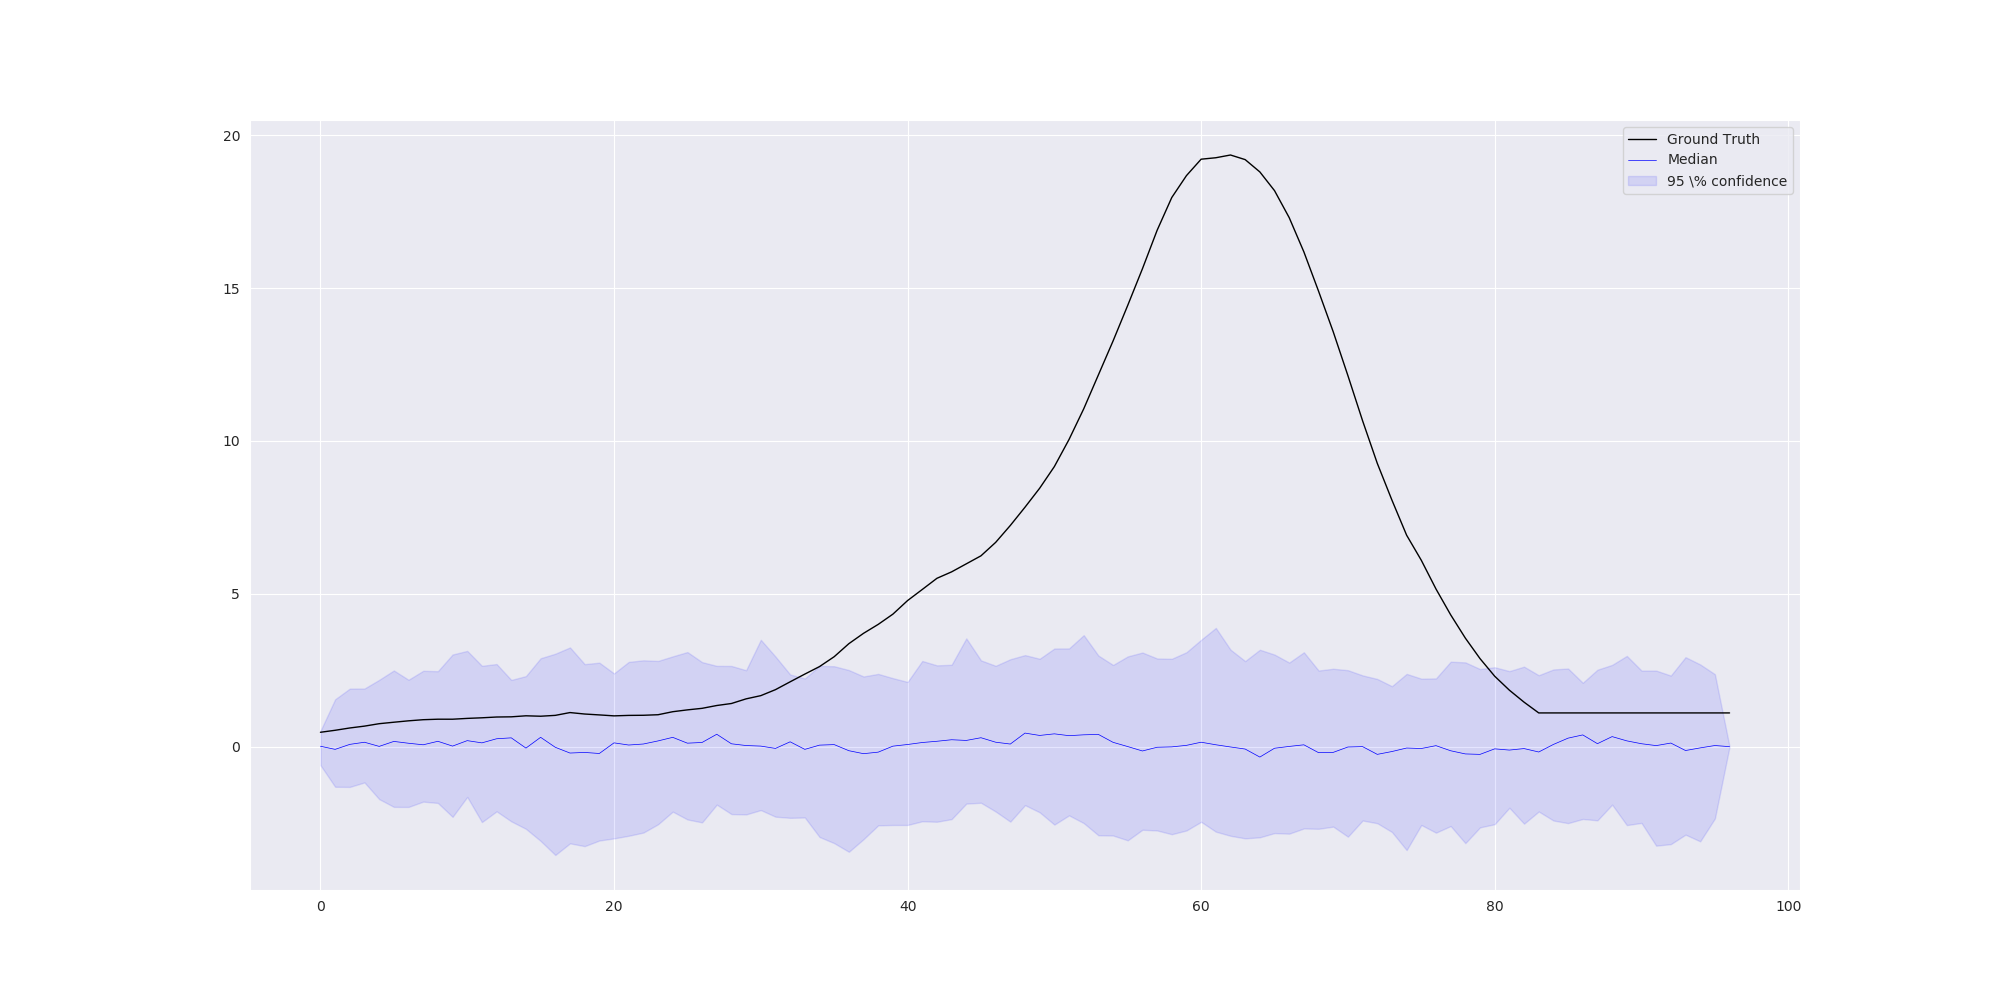